Epoch [1/100], Loss: 0.5613
Epoch [1/100], Train Loss: 0.6607, Val Loss: 0.4501
Epoch [2/100], Loss: 1.3647
Epoch [2/100], Train Loss: 0.5298, Val Loss: 0.5302
Epoch [3/100], Loss: 0.3737
Epoch [3/100], Train Loss: 0.4898, Val Loss: 0.3483
Epoch [4/100], Loss: 0.4426
Epoch [4/100], Train Loss: 0.4495, Val Loss: 0.2964
Epoch [5/100], Loss: 0.6170
Epoch [5/100], Train Loss: 0.4170, Val Loss: 0.3069
Epoch [6/100], Loss: 0.2713
Epoch [6/100], Train Loss: 0.4010, Val Loss: 0.3513
Epoch [7/100], Loss: 0.2427
Epoch [7/100], Train Loss: 0.3739, Val Loss: 0.2472
Epoch [8/100], Loss: 0.8277
Epoch [8/100], Train Loss: 0.3275, Val Loss: 0.2814
Epoch [9/100], Loss: 0.4308
Epoch [9/100], Train Loss: 0.3251, Val Loss: 0.3166
Epoch [10/100], Loss: 0.2007
Epoch [10/100], Train Loss: 0.3253, Val Loss: 0.2360
Epoch [11/100], Loss: 0.0772
Epoch [11/100], Train Loss: 0.2958, Val Loss: 0.2439
Epoch [12/100], Loss: 0.6735
Epoch [12/100], Train Loss: 0.2894, Val Loss: 0.2807
Epoch [13/100], Loss: 0.1262
Epoch

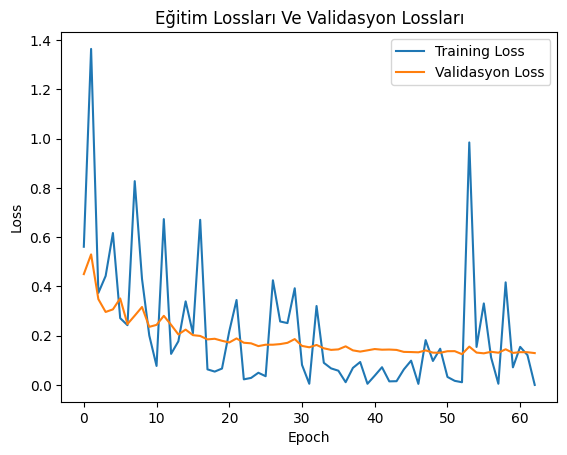

In [2]:
# Sadece early stopping yöntemi uygulanmış kod bloğu.

import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score


torch.manual_seed(170401060)

# Başlangıç zamanını kaydet
start_time = time.time()

# Veri setini oku
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

# Veriyi PyTorch Tensor'larına dönüştür
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(train_df.iloc[:, -1].values, dtype=torch.float32)
X_val = torch.tensor(val_df.iloc[:, :-1].values, dtype=torch.float32)
y_val = torch.tensor(val_df.iloc[:, -1].values, dtype=torch.float32)
X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)
y_test = torch.tensor(test_df.iloc[:, -1].values, dtype=torch.float32)

# MLP modelini tanımla
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Modeli oluştur
model = MLP()

# Loss fonksiyonunu tanımla
criterion = nn.BCELoss()

# Optimizasyon yöntemini tanımla
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Early stopping için değişkenleri tanımla
best_val_loss = float('inf')
best_epoch = 0
patience = 10
current_patience = 0

# Eğitim döngüsü
epochs = 100
batch_size = 16
train_losses = [] # Eğitim losslarını saklamak için bir liste
val_losses = [] # Validasyon losslarını saklamak için bir liste

for epoch in range(epochs):
    # Batch'lerle veriyi yükle
    model.train() # Modeli eğitim modunda kullan
    train_loss = 0.0
    indices = torch.randperm(X_train.shape[0])
    for i in range(0, X_train.shape[0], batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_X = X_train[batch_indices]
        batch_y = y_train[batch_indices]
        
        # Gradientleri sıfırla
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(batch_X)
        
        # Loss hesapla
        loss = criterion(y_pred.squeeze(), batch_y)
        
        # Backward pass
        loss.backward()
        
        # Parametreleri güncelle
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        
    train_loss /= X_train.shape[0]
    train_losses.append(loss.item())
    
    # Her epoch sonunda kaybı yazdır
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, epochs, loss.item()))
    

    # Modeli değerlendirme
    model.eval() 
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, X_val.shape[0], batch_size):
            batch_X = X_val[i:i+batch_size]
            batch_y = y_val[i:i+batch_size]
            y_pred = model(batch_X)
            loss = criterion(y_pred.squeeze(), batch_y)
            val_loss += loss.item() * batch_X.size(0)
        val_loss /= X_val.shape[0]
        val_losses.append(val_loss)
        
        # Validasyon Loss'unu yazdır.
        print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, epochs, train_loss, val_loss))
        
        # Early stopping kontrolü
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            current_patience = 0
        else:
            current_patience += 1
        
        if current_patience == patience:
            print(f"Early stopping triggered at epoch {epoch}, best validation loss: {best_val_loss:.4f}")
            break
            
# Eğitim süreci tamamlandıktan sonra zamanın bittiği noktayı kaydet
end_time = time.time()

# Toplam süreyi hesapla
total_time = end_time - start_time
               

# Test veri kümesinde doğruluk değerini hesapla
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, X_test.shape[0], batch_size):
        batch_X = X_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        y_pred = model(batch_X)
        loss = criterion(y_pred.squeeze(), batch_y)
        test_loss += loss.item() * batch_X.size(0)
        predicted = torch.round(y_pred).squeeze()
        correct += (predicted == batch_y).sum().item()
        total += batch_X.size(0)

test_loss /= X_test.shape[0]
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")
# Sonuçları ekrana yazdır
print(f"Toplam süre: {total_time:.2f} saniye")

# Tahminleri yap
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
    y_pred_classes = y_pred.argmax(dim=1)
    if y_test.ndim > 1:
        y_true = y_test.argmax(axis=1)
    else:
        y_true = y_test

# Confusion matrix'i hesapla
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Hassasiyet (precision) hesapla
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=1)

# Duyarlılık (recall) hesapla
recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=1)

# F1 değerini hesapla
f1 = 2 * (precision * recall) / (precision + recall)

# Sonuçları yazdır
print("Confusion Matrix:\n", confusion_mtx)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

    
# Training eğitim kaybını grafiğe dök
plt.plot(train_losses, label ='Training Loss')
plt.plot(val_losses, label='Validasyon Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim Lossları Ve Validasyon Lossları')
plt.legend()
plt.show()
    


Epoch [1/100], Loss: 0.5614
Epoch [1/100], Train Loss: 0.6599, Val Loss: 0.4493
Epoch [2/100], Loss: 1.3345
Epoch [2/100], Train Loss: 0.5309, Val Loss: 0.5229
Epoch [3/100], Loss: 0.4044
Epoch [3/100], Train Loss: 0.4901, Val Loss: 0.3488
Epoch [4/100], Loss: 0.4259
Epoch [4/100], Train Loss: 0.4500, Val Loss: 0.2973
Epoch [5/100], Loss: 0.6140
Epoch [5/100], Train Loss: 0.4173, Val Loss: 0.3137
Epoch [6/100], Loss: 0.2750
Epoch [6/100], Train Loss: 0.4018, Val Loss: 0.3644
Epoch [7/100], Loss: 0.2563
Epoch [7/100], Train Loss: 0.3739, Val Loss: 0.2479
Epoch [8/100], Loss: 0.8245
Epoch [8/100], Train Loss: 0.3280, Val Loss: 0.2996
Epoch [9/100], Loss: 0.4200
Epoch [9/100], Train Loss: 0.3242, Val Loss: 0.3075
Epoch [10/100], Loss: 0.2183
Epoch [10/100], Train Loss: 0.3245, Val Loss: 0.2300
Epoch [11/100], Loss: 0.0765
Epoch [11/100], Train Loss: 0.2933, Val Loss: 0.2412
Epoch [12/100], Loss: 0.7190
Epoch [12/100], Train Loss: 0.2894, Val Loss: 0.3172
Epoch [13/100], Loss: 0.1360
Epoch

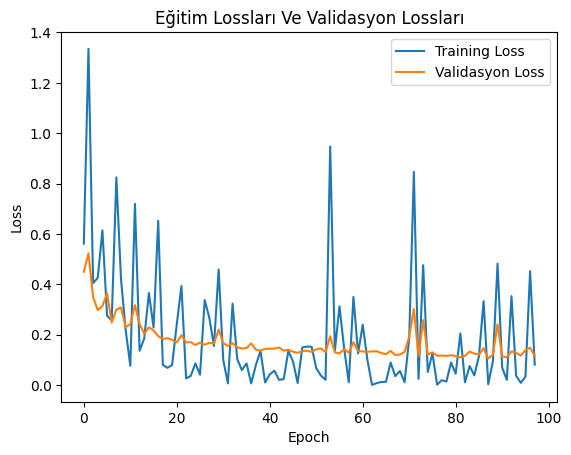

In [3]:
# Ridge regülarizasyonu ile birlikte early stopping yöntemi uygulanmış olan kod bloğu.
# Ekleyince test_accuracy değerim 0.9521'den 0.9534'e çıktı

import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score


torch.manual_seed(170401060)

# Başlangıç zamanını kaydet
start_time = time.time()

# Veri setini oku
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

# Veriyi PyTorch Tensor'larına dönüştür
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(train_df.iloc[:, -1].values, dtype=torch.float32)
X_val = torch.tensor(val_df.iloc[:, :-1].values, dtype=torch.float32)
y_val = torch.tensor(val_df.iloc[:, -1].values, dtype=torch.float32)
X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)
y_test = torch.tensor(test_df.iloc[:, -1].values, dtype=torch.float32)

# MLP modelini tanımla
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Modeli oluştur
model = MLP()

# Loss fonksiyonunu tanımla
criterion = nn.BCELoss()

# Optimizasyon yöntemini tanımla
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
# Ridge regülarizasyonu ekledik, weight_decay parametresi ile regülarizasyon katsayısını ayarladık.

# Early stopping için değişkenleri tanımla
best_val_loss = float('inf')
best_epoch = 0
patience = 10
current_patience = 0

# Eğitim döngüsü
epochs = 100
batch_size = 16
train_losses = [] # Eğitim losslarını saklamak için bir liste
val_losses = [] # Validasyon losslarını saklamak için bir liste

for epoch in range(epochs):
    # Batch'lerle veriyi yükle
    model.train() # Modeli eğitim modunda kullan
    train_loss = 0.0
    indices = torch.randperm(X_train.shape[0])
    for i in range(0, X_train.shape[0], batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_X = X_train[batch_indices]
        batch_y = y_train[batch_indices]
        
        # Gradientleri sıfırla
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(batch_X)
        
        # Loss hesapla
        loss = criterion(y_pred.squeeze(), batch_y)
        
        # Backward pass
        loss.backward()
        
        # Parametreleri güncelle
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        
    train_loss /= X_train.shape[0]
    train_losses.append(loss.item())
    
    # Her epoch sonunda kaybı yazdır
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, epochs, loss.item()))
    

    # Modeli değerlendirme
    model.eval() 
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, X_val.shape[0], batch_size):
            batch_X = X_val[i:i+batch_size]
            batch_y = y_val[i:i+batch_size]
            y_pred = model(batch_X)
            loss = criterion(y_pred.squeeze(), batch_y)
            val_loss += loss.item() * batch_X.size(0)
        val_loss /= X_val.shape[0]
        val_losses.append(val_loss)
        
        # Validasyon Loss'unu yazdır.
        print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, epochs, train_loss, val_loss))
        
        # Early stopping kontrolü
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            current_patience = 0
        else:
            current_patience += 1
        
        if current_patience == patience:
            print(f"Early stopping triggered at epoch {epoch}, best validation loss: {best_val_loss:.4f}")
            break
            
# Eğitim süreci tamamlandıktan sonra zamanın bittiği noktayı kaydet
end_time = time.time()

# Toplam süreyi hesapla
total_time = end_time - start_time
               

# Test veri kümesinde doğruluk değerini hesapla
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, X_test.shape[0], batch_size):
        batch_X = X_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        y_pred = model(batch_X)
        loss = criterion(y_pred.squeeze(), batch_y)
        test_loss += loss.item() * batch_X.size(0)
        predicted = torch.round(y_pred).squeeze()
        correct += (predicted == batch_y).sum().item()
        total += batch_X.size(0)

test_loss /= X_test.shape[0]
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")
# Sonuçları ekrana yazdır
print(f"Toplam süre: {total_time:.2f} saniye")

# Tahminleri yap
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
    y_pred_classes = y_pred.argmax(dim=1)
    if y_test.ndim > 1:
        y_true = y_test.argmax(axis=1)
    else:
        y_true = y_test

# Confusion matrix'i hesapla
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Hassasiyet (precision) hesapla
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=1)

# Duyarlılık (recall) hesapla
recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=1)

# F1 değerini hesapla
f1 = 2 * (precision * recall) / (precision + recall)

# Sonuçları yazdır
print("Confusion Matrix:\n", confusion_mtx)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

    
# Training eğitim kaybını grafiğe dök
plt.plot(train_losses, label ='Training Loss')
plt.plot(val_losses, label='Validasyon Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim Lossları Ve Validasyon Lossları')
plt.legend()
plt.show()
    


Epoch [1/100], Loss: 0.6191
Epoch [1/100], Train Loss: 0.6127, Val Loss: 0.3358
Epoch [2/100], Loss: 0.7585
Epoch [2/100], Train Loss: 0.3969, Val Loss: 0.2735
Epoch [3/100], Loss: 0.2533
Epoch [3/100], Train Loss: 0.3490, Val Loss: 0.2831
Epoch [4/100], Loss: 0.1256
Epoch [4/100], Train Loss: 0.3159, Val Loss: 0.2018
Epoch [5/100], Loss: 0.1793
Epoch [5/100], Train Loss: 0.2689, Val Loss: 0.2500
Epoch [6/100], Loss: 0.0667
Epoch [6/100], Train Loss: 0.2703, Val Loss: 0.1872
Epoch [7/100], Loss: 0.0358
Epoch [7/100], Train Loss: 0.2847, Val Loss: 0.2312
Epoch [8/100], Loss: 1.0900
Epoch [8/100], Train Loss: 0.2762, Val Loss: 0.2348
Epoch [9/100], Loss: 0.2629
Epoch [9/100], Train Loss: 0.2704, Val Loss: 0.3420
Epoch [10/100], Loss: 0.1964
Epoch [10/100], Train Loss: 0.3049, Val Loss: 0.2425
Epoch [11/100], Loss: 0.0376
Epoch [11/100], Train Loss: 0.2608, Val Loss: 0.1886
Epoch [12/100], Loss: 0.3339
Epoch [12/100], Train Loss: 0.2588, Val Loss: 0.2222
Epoch [13/100], Loss: 0.0588
Epoch

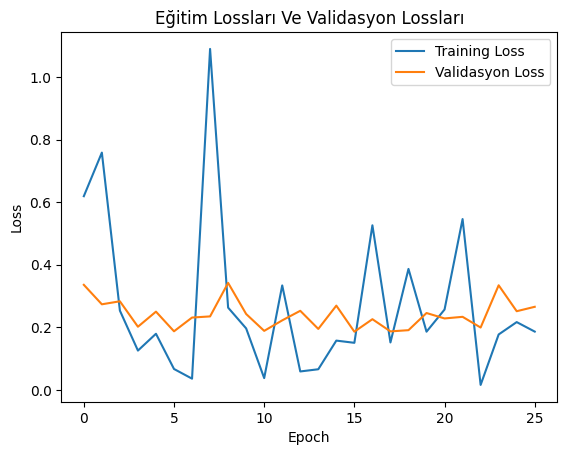

In [4]:
# Elastic Net regülarizasyonu ile birlikte early stopping yöntemi uygulanmış olan kod bloğu.
# Ekleyince test_accuracy değerim 94'ten 88'e düştü.

import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score


torch.manual_seed(170401060)

# Başlangıç zamanını kaydet
start_time = time.time()

# Veri setini oku
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

# Veriyi PyTorch Tensor'larına dönüştür
X_train = torch.tensor(train_df.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(train_df.iloc[:, -1].values, dtype=torch.float32)
X_val = torch.tensor(val_df.iloc[:, :-1].values, dtype=torch.float32)
y_val = torch.tensor(val_df.iloc[:, -1].values, dtype=torch.float32)
X_test = torch.tensor(test_df.iloc[:, :-1].values, dtype=torch.float32)
y_test = torch.tensor(test_df.iloc[:, -1].values, dtype=torch.float32)

# MLP modelini tanımla
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Modeli oluştur
model = MLP()

# Loss fonksiyonunu tanımla
criterion = nn.BCELoss()

# Optimizasyon yöntemini tanımla
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
# Elastic Net regülarizasyonunu ekledik, weight_decay parametresi ile regülarizasyon katsayısını ayarladık.

# Early stopping için değişkenleri tanımla
best_val_loss = float('inf')
best_epoch = 0
patience = 10
current_patience = 0

# Eğitim döngüsü
epochs = 100
batch_size = 16
train_losses = [] # Eğitim losslarını saklamak için bir liste
val_losses = [] # Validasyon losslarını saklamak için bir liste

for epoch in range(epochs):
    # Batch'lerle veriyi yükle
    model.train() # Modeli eğitim modunda kullan
    train_loss = 0.0
    indices = torch.randperm(X_train.shape[0])
    for i in range(0, X_train.shape[0], batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_X = X_train[batch_indices]
        batch_y = y_train[batch_indices]
        
        # Gradientleri sıfırla
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(batch_X)
        
        # Loss hesapla
        loss = criterion(y_pred.squeeze(), batch_y)
        
        # Backward pass
        loss.backward()
        
        # Parametreleri güncelle
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        
    train_loss /= X_train.shape[0]
    train_losses.append(loss.item())
    
    # Her epoch sonunda kaybı yazdır
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, epochs, loss.item()))
    

    # Modeli değerlendirme
    model.eval() 
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, X_val.shape[0], batch_size):
            batch_X = X_val[i:i+batch_size]
            batch_y = y_val[i:i+batch_size]
            y_pred = model(batch_X)
            loss = criterion(y_pred.squeeze(), batch_y)
            val_loss += loss.item() * batch_X.size(0)
        val_loss /= X_val.shape[0]
        val_losses.append(val_loss)
        
        # Validasyon Loss'unu yazdır.
        print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, epochs, train_loss, val_loss))
        
        # Early stopping kontrolü
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            current_patience = 0
        else:
            current_patience += 1
        
        if current_patience == patience:
            print(f"Early stopping triggered at epoch {epoch}, best validation loss: {best_val_loss:.4f}")
            break
            
# Eğitim süreci tamamlandıktan sonra zamanın bittiği noktayı kaydet
end_time = time.time()

# Toplam süreyi hesapla
total_time = end_time - start_time
               

# Test veri kümesinde doğruluk değerini hesapla
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, X_test.shape[0], batch_size):
        batch_X = X_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        y_pred = model(batch_X)
        loss = criterion(y_pred.squeeze(), batch_y)
        test_loss += loss.item() * batch_X.size(0)
        predicted = torch.round(y_pred).squeeze()
        correct += (predicted == batch_y).sum().item()
        total += batch_X.size(0)

test_loss /= X_test.shape[0]
accuracy = correct / total
print(f"Test accuracy: {accuracy:.4f}")
# Sonuçları ekrana yazdır
print(f"Toplam süre: {total_time:.2f} saniye")

# Tahminleri yap
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
    y_pred_classes = y_pred.argmax(dim=1)
    if y_test.ndim > 1:
        y_true = y_test.argmax(axis=1)
    else:
        y_true = y_test

# Confusion matrix'i hesapla
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Hassasiyet (precision) hesapla
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=1)

# Duyarlılık (recall) hesapla
recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=1)

# F1 değerini hesapla
f1 = 2 * (precision * recall) / (precision + recall)

# Sonuçları yazdır
print("Confusion Matrix:\n", confusion_mtx)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

    
# Training eğitim kaybını grafiğe dök
plt.plot(train_losses, label ='Training Loss')
plt.plot(val_losses, label='Validasyon Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim Lossları Ve Validasyon Lossları')
plt.legend()
plt.show()
    
